In [1]:
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne

from jax import config
config.update("jax_enable_x64", True)

I0000 00:00:1708764840.745189       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
base_temp = jnp.log10(5700)
spot_temp = jnp.log10(20000)
spot_diff = spot_temp - base_temp

In [3]:
# tpayne = TransformerPayne.download()

In [4]:
tp = TransformerPayne.download()

/Users/mjablons/spectral-emulator/src/transformer_payne/transformer_payne.py:121: UserWarning: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte Downloading the model from HuggingFace.
  warnings.warn(str(e) + " Downloading the model from HuggingFace.")
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., tp.to_parameters(dict(logteff=5700)))
m = add_spots(mesh=m,
              thetas=jnp.array([1.]),
              phis=jnp.array([0.]),
              param_deltas=jnp.array([spot_diff]),
              radii=jnp.array([0.25]),
              radius_factors=jnp.array([.75]),
              param_indices=jnp.array([0]))

/Users/mjablons/spectral-emulator/src/transformer_payne/transformer_payne.py:206: UserWarning: Possible exceeding parameter bonds - extrapolating.
  warnings.warn("Possible exceeding parameter bonds - extrapolating.")


In [6]:
mt = add_rotation(m, 100, jnp.array([0., 0., 1.]))
mts = [evaluate_rotation(mt, t) for t in np.linspace(0, 3600*10, 10)]

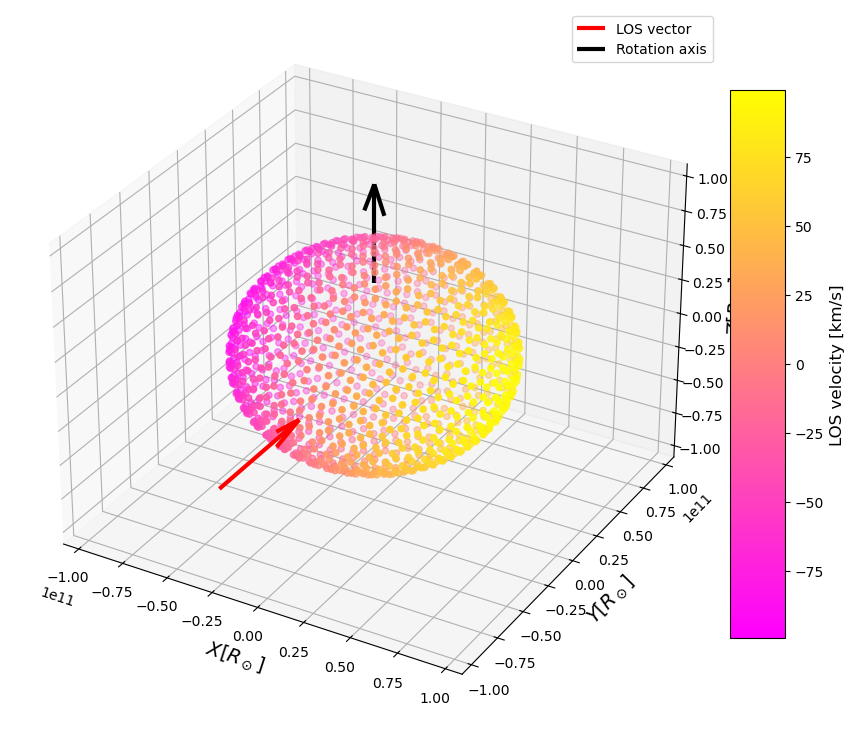

In [7]:
_, p, _ = plot_3D(mts[0], 'los_velocities', cmap='spring')

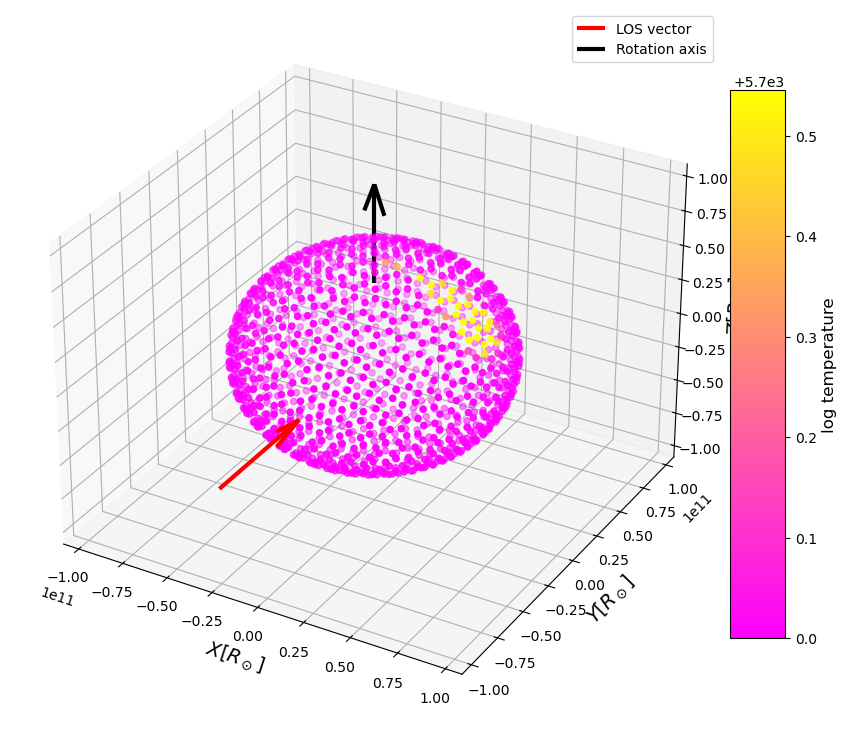

In [8]:
_, p, _ = plot_3D(mts[0], 0, cmap='spring', property_label='log temperature')

In [9]:
import matplotlib.pyplot as plt

vws = jnp.linspace(1000., 20000., 100)

In [10]:
from spectrum.spectrum import spectrum_flash_sum

In [16]:
import jax
C: float = 299792.458 # km/s

apply_vrad = lambda x, vrad: x*(vrad/C + 1)
apply_vrad_log = lambda x, vrad: x+jnp.log10(vrad/C + 1)
v_apply_vrad = jax.jit(jax.vmap(apply_vrad, in_axes=(None, 0)))

# n_wavelengths, n_vertices
v_apply_vrad_log = jax.jit(jax.vmap(apply_vrad_log, in_axes=(None, 0), out_axes=0))
v_intensity = jax.jit(jax.vmap(lambda wv, m, p:
                                   jax.vmap(tp.intensity,
                                            in_axes=(0, 0, 0))(wv, m, p),
                                    in_axes=(0, None, None)))

In [17]:
m.areas.shape, m.parameters.shape, m.mus.shape, m.los_velocities.shape

((1280,), (1280, 95), (1280,), (1280,))

In [18]:
v_apply_vrad_log(jnp.log10(vws), m.los_velocities.reshape((-1, 1))).shape

(1280, 100)

In [20]:
m.mus.shape, m.parameters.shape

((1280,), (1280, 95))

In [21]:
v_intensity(v_apply_vrad_log(jnp.log10(vws), m.los_velocities.reshape((-1, 1))), m.mus[:, jnp.newaxis], m.parameters)

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 1280, e.g. axis 0 of argument mu of type float64[1280,1];
  * one axis had size 100: axis 0 of argument log_wavelengths of type float64[100]

In [15]:
spectrum_flash_sum(tp.intensity, jnp.log10(vws), m.areas,
                   jnp.where(m.mus>0, m.mus, 0.),
                   m.los_velocities,
                   m.parameters,
                   64)
    # 108                               log_wavelengths,
    # 109                               m.areas,
    # 110                               jnp.where(m.mus>0, m.mus, 0.),
    # 111                               m.los_velocities,
    # 112                               m.parameters,
    # 113                               chunk_size)

ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 64, e.g. axis 0 of argument mu of type float64[64,1];
  * one axis had size 100: axis 0 of argument log_wavelengths of type float64[100]

In [22]:
i = simulate_spectrum(tp.intensity, m, jnp.log10(vws))
plt.plot(vws, i[:, 0], color='red', alpha=0.5)

for _mt in mts:
    i = simulate_spectrum(tp.intensity, _mt, jnp.log10(vws), 16)
    plt.plot(vws, i[:, 1], color='black', alpha=0.5)

plt.gca().set_ylim(0, 1e7)

/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


ValueError: Incompatible shapes for broadcasting: (95,) and requested shape (94,)

In [11]:
jnp.sum(i[:, 0])

Array(88048522.17842747, dtype=float64)